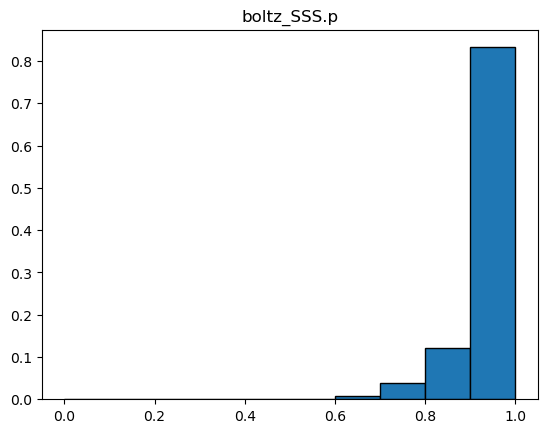

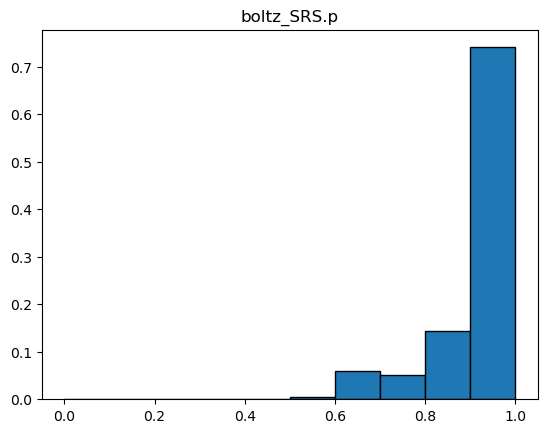

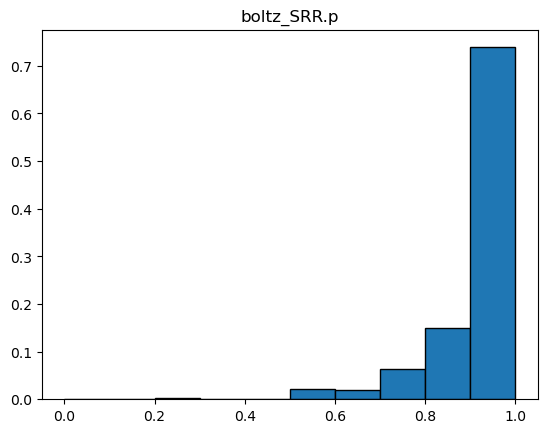

In [25]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

def load_and_plot(filename):

    with open(filename, 'rb') as file:
        data = pickle.load(file)

    # Plot results
    # Define bins
    bins = [0.0,0.1,0.2,0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

    # Create histogram with bar heights summing to 1
    probs,bins,_ = plt.hist(data["D12"]+data["D23"], bins=bins, edgecolor='black', weights=np.array(data["P"]+data["P"])/2.0)
    plt.title(f"{filename}")
    plt.show()
    for_return = {}
    for_return["p"] = data["P"]
    for_return["s"] = np.mean(data["S12"] + data["S23"])
    for_return["a"] = [ (data["D12"][_],data["D23"][_]) for _ in range(len(data["P"])) ]
    return for_return

isotactic = load_and_plot("boltz_SSS.p")
syndiotactic = load_and_plot("boltz_SRS.p")
atactic = load_and_plot("boltz_SRR.p")


In [ ]:
def rotate_vector(vector, angle):
    """
    Rotates a 2D vector by a given angle in radians.
    
    Parameters:
    - vector: 2D numpy array representing the vector to be rotated.
    - angle: Rotation angle in radians.
    
    Returns:
    - Rotated 2D vector as a numpy array.
    """
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                                [np.sin(angle), np.cos(angle)]])
    rotated_vector = np.dot(rotation_matrix, vector)
    return rotated_vector

# sliding average of dot products
def corr(vectors,size=100):
    """
    Calculates the average dot products between the i and i+nth vector in the set
    where size controls how large the displacement is and vectors 0-len(vectors)-size 
    serve as distinct origins for the average. For example, if vectors contains 100
    vectors, and size is 10. Then the dot product between 0 and 0-9 will be calculated, 
    between 1 and 1-10, 2 and 2-11, ..., 90 and 90-99. The returned result is averaged
    over all origins (0,1,2...90 in the example).
    
    Parameters:
    - vectors: numpy array of vectors
    - size: scalar corresponding to the displacements that the user cares about. 
    
    Returns:
    - mean(i,i+d): numpy array of scalars corresponding to the mean dot product for 
      a displacement of d between the vectors. 
    """
    vals = np.zeros(size)
    for i in range(len(vectors)-size):
        vals = vals + np.array([ np.dot(vectors[i],_) for _ in vectors[i:i+size] ])
    return vals/(len(vectors)-size+1)

def simulate(data,size=250000):

    rots = np.random.choice(np.arange(len(data["p"])),p=data["p"],size=size)
    rots = [ j for i in rots for j in data["a"][i] ]
    rots = np.arccos(rots)*np.random.choice([1,-1],size=len(rots))
    
    # Perform rotations
    data["vecs"] = [np.array([1.,0.])]
    data["dots"] = []
    for count_i,i in enumerate(rots):
        data["vecs"].append(rotate_vector(data["vecs"][-1],i)) # Add new vector that satisfies dot product result
        data["dots"].append(np.dot(data["vecs"][-2],data["vecs"][-1])) # store dot product distribution for comparison with generating distribution
        
    # calculate correlation
    data["alignment"] = corr(data["vecs"],100)
    
    # calculate correlation length
    thresh = 1.0/np.e
    for count_i,i in enumerate(data["alignment"]):
        if i < 1.0/np.e:
            data["p_n"] = count_i-1
            data["p_len"] = data["p_n"]*3.5/10.0
            break
    return data

isotactic = simulate(isotactic)
syndiotactic = simulate(syndiotactic)
atactic = simulate(atactic)


isotactic['p_n']=17
syndiotactic['p_n']=11
atactic['p_n']=11
iso alignment probabilities: [0.       0.       0.       0.       0.       0.001396 0.007588 0.037812
 0.120504 0.8327  ]
syndio alignment probabilities: [0.       0.       0.       0.       0.       0.004622 0.059322 0.052676
 0.14337  0.74001 ]
atactic alignment probabilities: [0.       0.       0.003226 0.       0.001694 0.022666 0.019396 0.064278
 0.149934 0.738806]


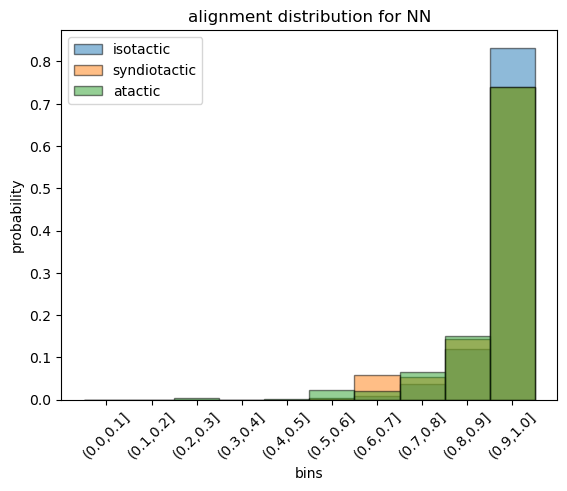

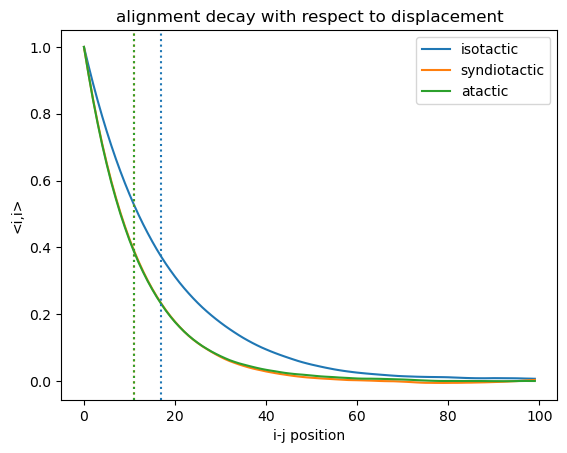

In [52]:
# Print out the correlation length
print(f"{isotactic['p_n']=}")
print(f"{syndiotactic['p_n']=}")
print(f"{atactic['p_n']=}")

# Create histogram with bar heights summing to 1
bins = [0.0,0.1,0.2,0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
weights = np.ones_like(isotactic["dots"]) / len(isotactic["dots"])
p,_,_=plt.hist(isotactic["dots"], bins=bins, edgecolor='black', weights=weights, alpha=0.5, label="isotactic")
print(f"iso alignment probabilities: {p}")
weights = np.ones_like(syndiotactic["dots"]) / len(syndiotactic["dots"])
p,_,_=plt.hist(syndiotactic["dots"], bins=bins, edgecolor='black', weights=weights, alpha=0.5, label="syndiotactic")
print(f"syndio alignment probabilities: {p}")
weights = np.ones_like(atactic["dots"]) / len(atactic["dots"])
p,_,_=plt.hist(atactic["dots"], bins=bins, edgecolor='black', weights=weights, alpha=0.5, label="atactic")
print(f"atactic alignment probabilities: {p}")
bin_labels = [f"({bins[i]},{bins[i+1]}]" for i in range(len(bins)-1)] # Set x-tick labels to correspond to the range of each bin
tick_positions = [np.mean([bins[i], bins[i+1]]) for i in range(len(bins)-1)] # Calculate the positions for the ticks to be in the middle of each bin
plt.xticks(ticks=tick_positions, labels=bin_labels, rotation=45)
plt.title("alignment distribution for NN")
plt.xlabel('bins')
plt.ylabel('probability')
plt.legend()
plt.show()

# Plot the correlation decays
line1,=plt.plot(np.arange(len(isotactic["alignment"])),isotactic["alignment"],label="isotactic")
line2,=plt.plot(np.arange(len(syndiotactic["alignment"])),syndiotactic["alignment"],label="syndiotactic")
line3,=plt.plot(np.arange(len(atactic["alignment"])),atactic["alignment"],label="atactic")

# Adding dotted vertical lines at particular points
plt.axvline(x=isotactic['p_n'], color=line1.get_color(), linestyle=':', label=None)
plt.axvline(x=syndiotactic['p_n'], color=line2.get_color(), linestyle=':', label=None)
plt.axvline(x=atactic['p_n'], color=line3.get_color(), linestyle=':', label=None)
plt.title("alignment decay with respect to displacement")
plt.xlabel('i-j position')
plt.ylabel('<i,i>')

plt.legend()
plt.savefig("alignment.pdf")
plt.show()
